In [84]:
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

# 1. Target Function
1. Let's create a `target 1-D function with multiple local maxima` to test and visualize how the `BayesianOptimization` package works.
2. The target function we will try to maximize is the following:

$\begin{aligned}
f(x) = e^{-(x-2)^2} + e^{-\frac{(x-6)^2}{10}} + \frac{1}{x^2+1}
\end{aligned}$

3. its maximum is at $x=2$ and we will restrict the interval of interest to $x \in (-2, 10)$.

<font color="red" size="4">

Notice
------
1. Notice that, in practice, `this function is unknown`, `the only information we have is obtained by sequentialy probing it at different points`.
2. `BayesianOptimization` works by contructing `a posterior distribution of functions that best fit the data observed` and `chosing the next probing point by balancing exploration and exploitation`.

</font>

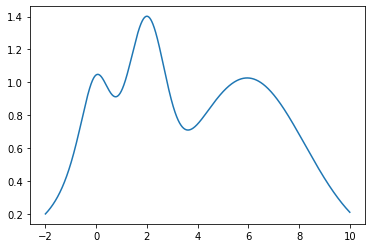

In [105]:
### 1. target function
def target(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)


### 2. Generate data
x = np.linspace(-2, 10, 10000).reshape(-1, 1)
y = target(x)

plt.plot(x, y)

# 2. Create a `BayesianOptimization` Object
1. Enter the `target function` to be maximized, its variable(s) and their `corresponding ranges`. 
2. A minimum number of `2 initial guesses` is necessary to kick start the algorithms
    - These can either be `random` or `user defined`.

In [106]:
optimizer = BayesianOptimization(
                f=target,
                pbounds={'x': (-2, 10)},
                random_state=27,
                )

3. In this example we will use the `Upper Confidence Bound (UCB)` as our `utility function`.
    - It has the free parameter $\mathcal{K}$ which control the balance between exploration and exploitation
    - We will set $\mathcal{K}=5$ which, in this case, makes the algorithm quite bold.

In [107]:
optimizer.maximize(
            init_points=2,
            n_iter=0,
            acq='ucb',
            kappa=5,
            )

|   iter    |  target   |     x     |
-------------------------------------
|  1        |  0.8198   |  3.109    |
|  2        |  0.746    |  7.775    |


# 3. Plotting and visualizing the algorithm at each step

In [108]:
### 1. 后验数据分布
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma


### 2. 绘图函数
def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
            f'Gaussian Process and Utility Function After {steps} Steps.',
            fontdict={'size': 30},
            )

    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])

    x_obs = np.array( [[res["params"]["x"]] for res in optimizer.res] ) # 列向量形式
    y_obs = np.array( [res["target"] for res in optimizer.res] )    # 行向量形式，shape = (N,)

    mu, sigma = posterior(
                    optimizer=optimizer,
                    x_obs=x_obs,
                    y_obs=y_obs,
                    grid=x,
                    )
    axis.plot(x, y, linewidth=3, label="Target")
    axis.scatter(
                x_obs.ravel(), y_obs.ravel(), 
                s=80, marker='D',
                label=u"Observations", 
                color='r',
                )
    axis.plot(x, mu, '--', color='k', label="Prediction")

    axis.fill_between(
                x.ravel(),
                mu.ravel() + 1.96 * sigma.ravel(),
                mu.ravel() - 1.96 * sigma.ravel(),
                alpha=0.5,
                label='95% confidence interval',
                )

    axis.set_xlim((-2, 10))        
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size': 20})
    axis.set_xlabel('x', fontdict={'size': 20})


    utility_function = UtilityFunction(
                            kind='ucb',
                            kappa=5,
                            xi=0,
                            )
    utility = utility_function.utility(
                            x=x,
                            gp=optimizer._gp,
                            y_max=0
                            )
    acq.plot(x, utility, label="Utility Function", color="Purple")
    acq.plot(x[np.argmax(utility)], np.max(utility),
            '*', markersize=15,
            label=u'Next Best Guess', markerfacecolor='gold',
            markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((-2, 10))            
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})

    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

    plt.show()

# Show 1. Two random points
1. After we `probe two points at random`, we can fit a `Gaussian Process` and start the bayesian optimization procedure. 
2. Two points should give us a uneventful posterior with the uncertainty growing as we go further from the observations.

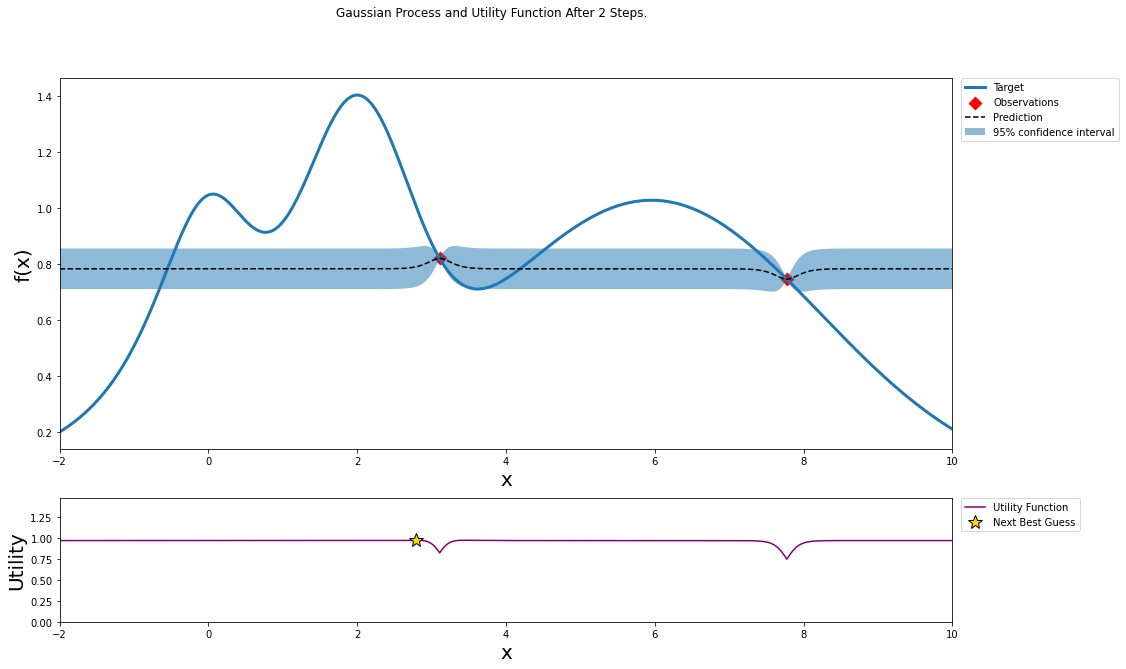

In [109]:
plot_gp(optimizer, x, y)

# Show 2. After 1 step of GP (and two random points)

|   iter    |  target   |     x     |
-------------------------------------
|  3        |  0.5234   | -0.9694   |


/Users/mac/opt/anaconda3/envs/research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


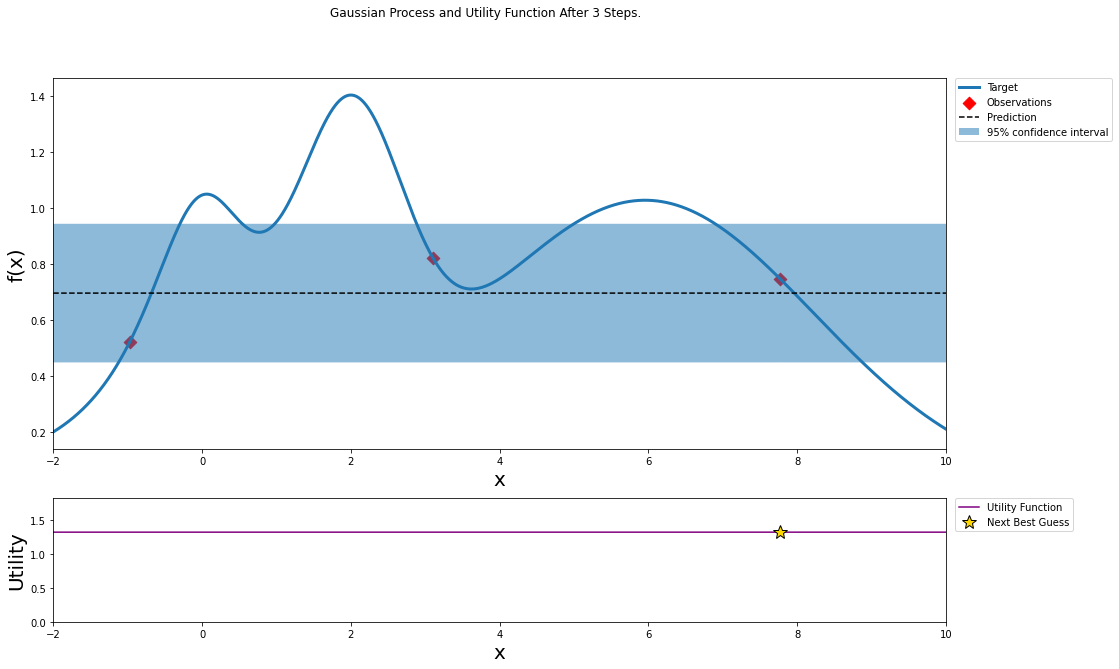

In [110]:
optimizer.maximize(init_points=0,
                n_iter=1,
                acq='ucb',
                kappa=5
                )
plot_gp(optimizer, x, y)

# Show 3. After 2 step of GP (and two random points)

|   iter    |  target   |     x     |
-------------------------------------
|  4        |  0.8164   |  3.116    |


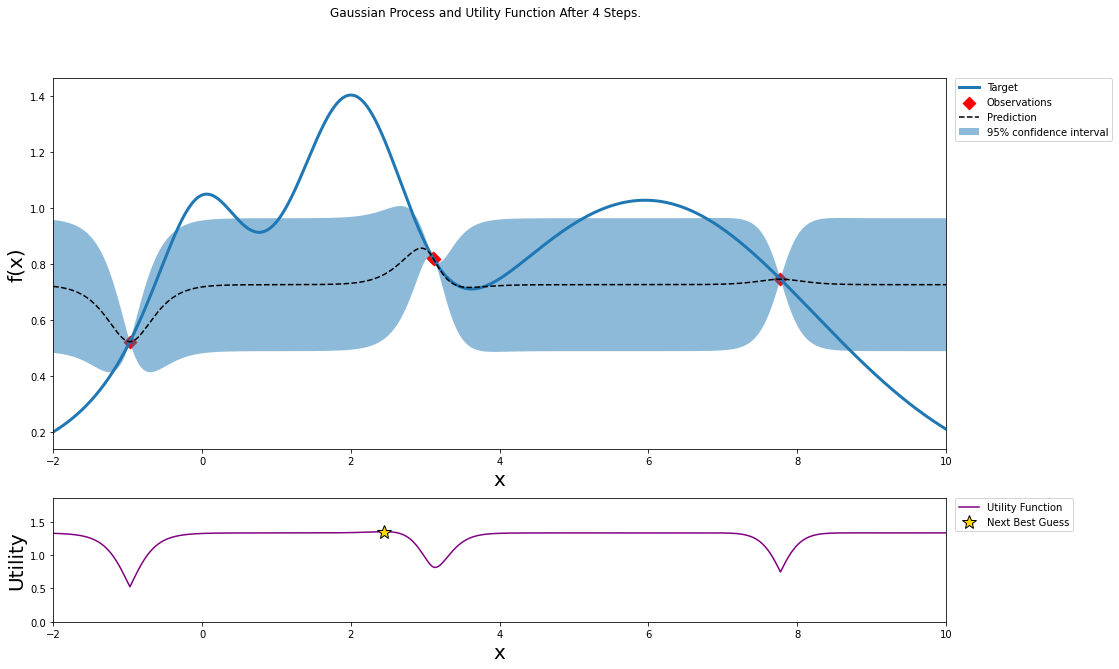

In [111]:
optimizer.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(optimizer, x, y)

# Show 4. After 3 step of GP (and two random points)

|   iter    |  target   |     x     |
-------------------------------------
|  5        |  1.243    |  2.449    |


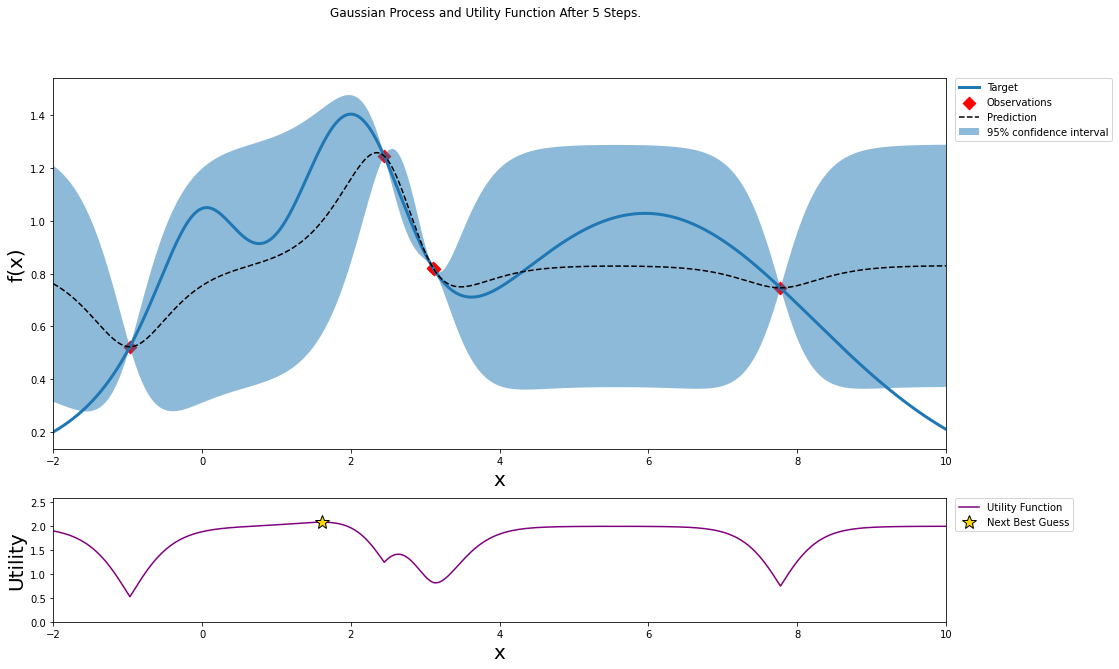

In [112]:
optimizer.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(optimizer, x, y)

# Show 5. After 4 step of GP (and two random points)

|   iter    |  target   |     x     |
-------------------------------------
|  6        |  1.283    |  1.61     |


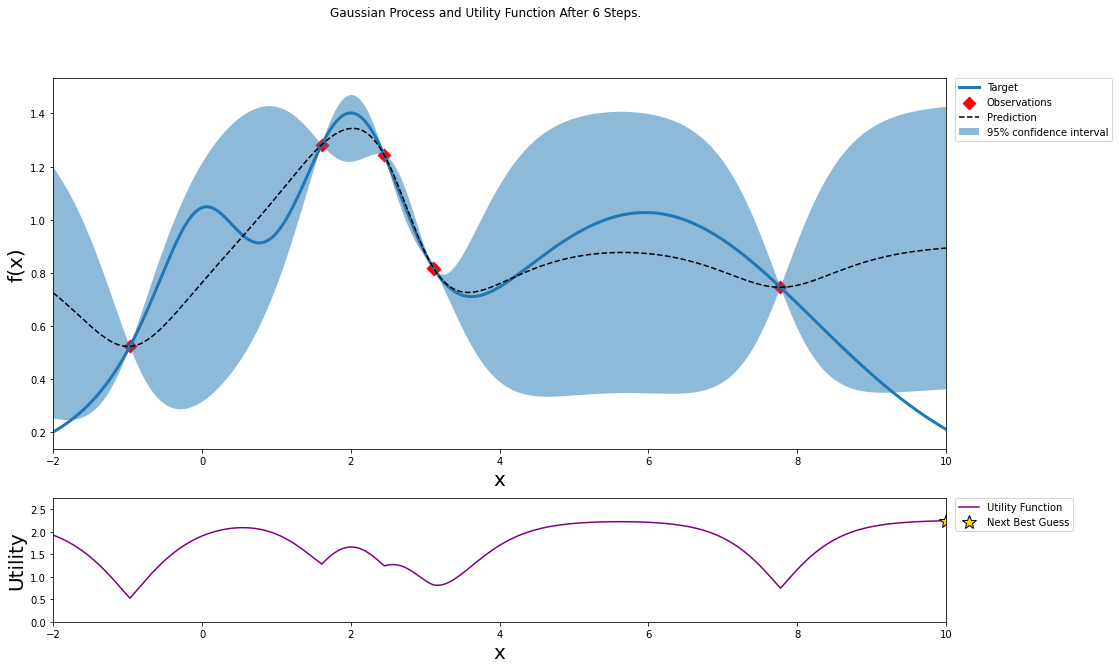

In [113]:
optimizer.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(optimizer, x, y)

# Show 6. After 5 step of GP (and two random points)

|   iter    |  target   |     x     |
-------------------------------------
|  7        |  0.2118   |  10.0     |


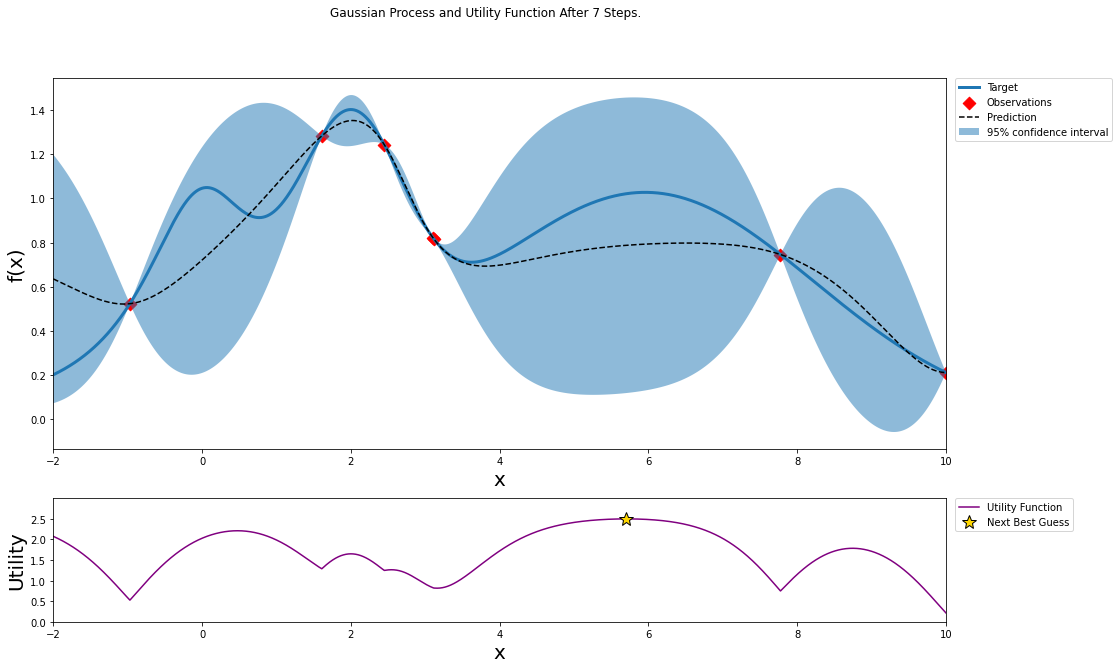

In [114]:
optimizer.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(optimizer, x, y)

# Show 7. After 6 step of GP (and two random points)

|   iter    |  target   |     x     |
-------------------------------------
|  8        |  1.021    |  5.704    |


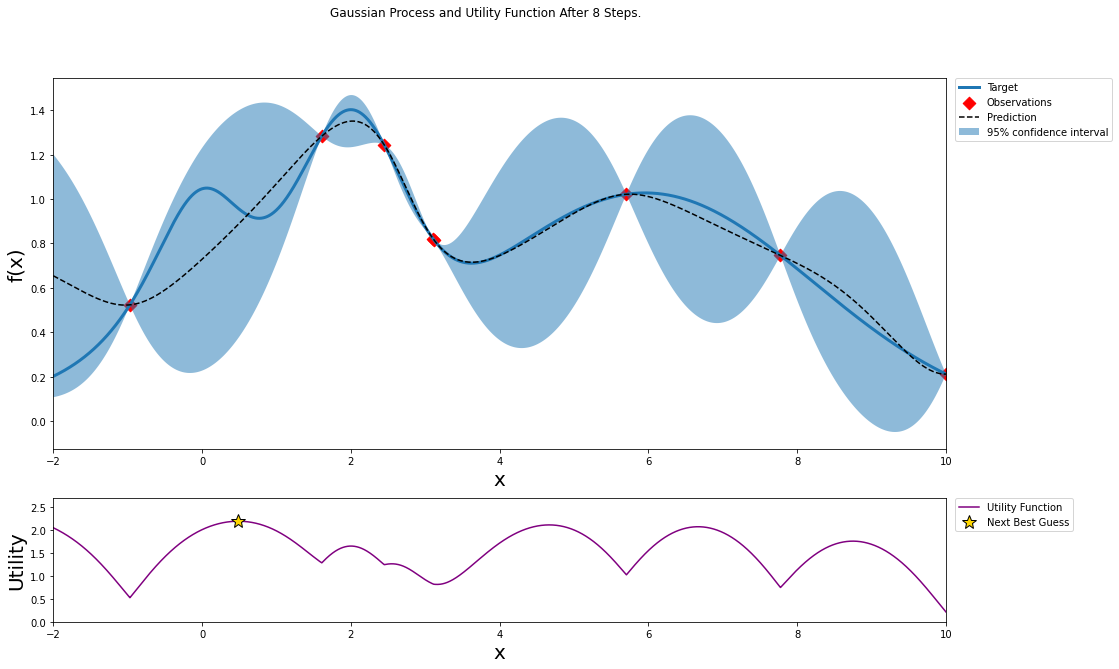

In [115]:
optimizer.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(optimizer, x, y)

# Show 8. After 7 step of GP (and two random points)

|   iter    |  target   |     x     |
-------------------------------------
|  9        |  0.9572   |  0.488    |


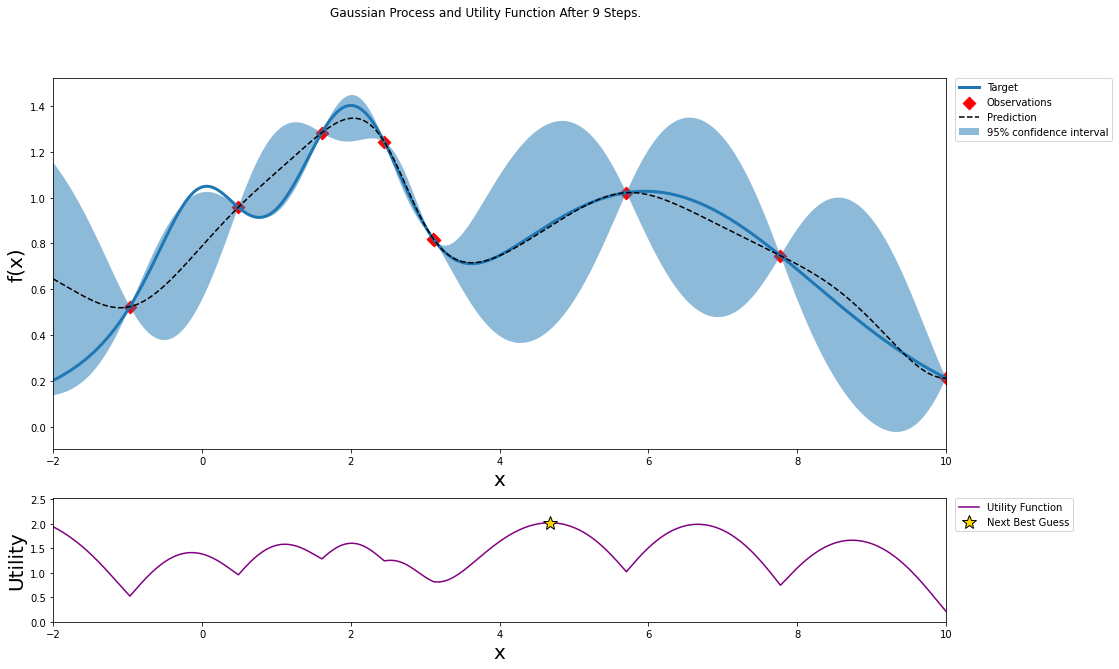

In [116]:
optimizer.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(optimizer, x, y)